<a href="https://colab.research.google.com/github/kesadilya/eskwelabs/blob/master/Suggestion_Feature_Procurement_Decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strategizing grocery shopping

In shopping for groceries, an individual would usually create a list of items that need to be bought based on the stock level of household items and goods. However, doing the grocery in itself is a tedious job, and so a buyer would need to strategize what to buy first and what items can be grabbed together (as similar items are placed next to each other).

In an organization setting, procurement or the process of buying does not really differ much, except that the grocery list expands from a thousand to a million items that need to be bought everyday. Procurement is also not limited to buying goods, but also to setting contracts on service/s to be rendered. With procurement becoming large scale, below is a simplified decision on items that needs to be bought:

    1. Withdraw from inventory if item is still available;
    2. If there is a binding contract, immediately proceed with the purchase; and
    3. Strategize on bundling opportunities
    
With procurement magnified, efficiency issues also increases. Goods and/or services are bought on a daily basis, in a repetitive manner especially when similar items appear on different requests. Buyers are also pressured to immediately buy, while also negotiating with suppliers to lower down procurement costs.

Thus, the aim of this project is to automate procurement decisions that would otherwise be very tedious. This would help in increasing cost savings, and in the efficiency of the overall procurement process. 

# Summary of Results
With the recommendation engine fully in production, lead time from transforming a purchase request to a purchase order may be reduced by at least 2 days. This is a lot considering that 30,000 purchase requests are being processed every year. However, there is a need to further improve:

1. Accuracy of predicting category assignment, and to consider expanding the assignments to specific buyers instead;
2. Improving intuition of bundle networks: identifying other offerings of variety of vendors by capturing bid data; and
3. Expanding inventory check to be more proactive: create additional purchase requests based on reorder point of materials.

# Exploring Existing Data
This project will use data from an energy company. There are three main data sources that are readily available or has a defined data architecture in the company database.

    1. Historical spend data of 6 years;
    2. Dynamic outstanding purchase requests; and
    3. Inventory stock level
    
With these data sources, setup on organization procurement process (what teams handle what items), and average volume of requests would readily be known.

In [0]:
#Connect to organization team drive and sync to uploaded database file
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
db_path = "/gdrive/Shared drives/Performance Analytics/data_processed/sap_20190701.db" #change date to get latest update

import pandas as pd
import sqlalchemy as sqla

eng = sqla.create_engine("sqlite:///" + db_path)
with eng.begin() as con:
  df_purch = pd.read_sql_query("select * from sap_purchase_items", con)
  
#Connect to organization team drive and sync to uploaded spend data
drive.mount('/gdrive', force_remount=True)
csv_path = "/gdrive/Shared drives/Performance Analytics/report_library/spend_cube_files/2013-20190531 Awarded PO + Contract Data Finaledits v36.csv"
df_spend = pd.read_csv(csv_path, encoding='latin1')
df_spend['Material'] = df_spend['Material'].astype(str)

eng = sqla.create_engine("sqlite:///" + db_path)
with eng.begin() as con:
  df_purch_zmm = pd.read_sql_query("select * from sap_zmmprstat", con)
  
  
csv_path2 = "/gdrive/Shared drives/Performance Analytics/data_extracts/materials_management/MB51_06_2019.csv"
csv_path3 = "/gdrive/Shared drives/Performance Analytics/data_extracts/materials_management/MB52_06282019.csv"
df_inv_move = pd.read_csv(csv_path2, encoding='latin1')
df_inv_stock = pd.read_csv(csv_path3, encoding ='latin1')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
Mounted at /gdrive


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,20,23,34,41,44,46,47,48,52,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. Spend Data Quality - shown below is a snippet of the spend data. The cleaned data contains all the processed purchase request (also called purchase orders) from 2013 - May 2019 with additional calculated fields mainly:

    a. Material Hierarchies - based on the material group or the UNSPSC codes;
    
    b. Spend Type - whether operational, capital or inventory related application expense;
    
    c. Spend in PHP - other currencies were converted to peso as well
      

In [0]:
df_spend.head()

,Purchasing Document,Item,Document Date,Name of Vendor,Material,Material Group,Short Text,Cleaned Short Text,Order Quantity,Order Unit,Order Unit - Full,Net price,Net Order Value,Order Price Unit,Currency,Plant,Purchasing Group,Outline Agreement,Purchasing Doc. Type,Unique Code,CODE,Vendor Name,Cleaned Vendor Name,Vendor Type,Country,PO Amount in PHP,Buyer Name,BU Processor,Plant Intended,Cleaned Plant Intended,BU Intended,Document Type,Goods / Services,Charged To,Month,Year,Segment,Family,Class,Contract No.2,BCG Level 0,Per,Q Year,M Year,OEM vs NON OEM Tag (Place holder),Vendor Telephone,Origin country (Logistics),PR #,PR line item,PR Approve Date,Contract start date2,Contract end date2,Contract amount,Contract currency (Local currency),Contract type2,Contract execution date2,Buyer,GROUP,Proponent,Contractor's Name2,Title of Contract3,Remarks,Contract amount (PHP),Delivery Date,Unnamed: 64,Unnamed: 65
0,305417,10,05/17/2013,200059 INTEGRAL INDUSTRIAL MANA,1812.0,31251502,"ACTUATOR; HYDRAULIC, FOR 20"" BUTTERFLY V","Actuator; Hydraulic, For 20"" Butterfly V",1.0,ASY,Asembly,54880.50,54880.50,ASY,USD,100H,H10,NaN,MB,305417_10,200059,INTEGRAL INDUSTRIAL MANA,INTEGRAL INDUSTRIAL MANAGEMENT CORP.,Mechanical Supplies,PH,2731347.61,HAW Alcantara,HO,LGBU UPPER MAHIAO POWER WREHSE,Leyte Geothermal Business Unit Upper Mahiao Po...,LGBU,Migration PO,GOODS,OPEX,May,2013,Manufacturing Components and Supplies,Pneumatic and hydraulic and electric control s...,Actuators,,FCRS,1,Q2 2013,M5 2013,OEM,(02)3554744,NaN,7e+09,10,,,,,,,,,,,,,,,11/07/2013,NaN,NaN
1,305417,20,05/17/2013,200059 INTEGRAL INDUSTRIAL MANA,1813.0,31251502,"ACTUATOR; HYDRAULIC, FOR 8"" BUTTERFLY VA","Actuator; Hydraulic, For 8"" Butterfly Va",1.0,ASY,Asembly,43445.86,43445.86,ASY,USD,100H,H10,NaN,MB,305417_20,200059,INTEGRAL INDUSTRIAL MANA,INTEGRAL INDUSTRIAL MANAGEMENT CORP.,Mechanical Supplies,PH,2162257.01,HAW Alcantara,HO,LGBU UPPER MAHIAO POWER WREHSE,Leyte Geothermal Business Unit Upper Mahiao Po...,LGBU,Migration PO,GOODS,OPEX,May,2013,Connections and adhesives,Pneumatic and hydraulic and electric control s...,Actuators,,FCRS,1,Q2 2013,M5 2013,OEM,(02)3554744,NaN,7e+09,20,01/18/2013,,,,,,,,,,,,,,11/07/2013,NaN,NaN
2,411304261,10,06/13/2013,300019 INDUSTRIAL CONTROLS SYST,55335.0,31251505,KIT;RESOLVER DRIVE & PCB;IQ70F25A;ROTORK,Kit;Resolver Drive & Pcb;Iq70F25A;Rotork,2.0,SET,Set,71312.50,142625.00,SET,PHP,100D,LG4,NaN,MB,411304261_10,300019,INDUSTRIAL CONTROLS SYST,INDUSTRIAL CONTROLS SYSTEMS INCORPORATED,Mechanical Supplies,PH,142625.00,RB Enero,LGBU,LGBU CENTRAL WAREHOUSE,Leyte Geothermal Business Unit Central Warehouse,LGBU,Migration PO,GOODS,OPEX,Jun,2013,Connections and adhesives,Pneumatic and hydraulic and electric control s...,Actuators,,Power Plant,1,Q2 2013,M6 2013,OEM,(02)4287456,NaN,0,NaN,,,,,,,,,,,,,,,07/18/2013,NaN,NaN
3,305708,30,06/18/2013,300144 TOSHIBA CORPORATION,56368.0,31251505,KIT;REPAIR;TOSHIBA MSV ACTUATOR,Kit;Repair;Toshiba Msv Actuator,1.0,SET,Set,3320.00,3320.00,SET,USD,100G,H11,NaN,MB,305708_30,300144,TOSHIBA CORPORATION,TOSHIBA CORPORATION,Power Plant Professional Services,JP,165233.08,RR Bongco,HO,LGBU MAHANAGDONG POWER WAREHSE,Leyte Geothermal Business Unit Mahanagdong Pow...,LGBU,Migration PO,GOODS,OPEX,Jun,2013,Connections and adhesives,Pneumatic and hydraulic and electric control s...,Actuators,,Power Plant,1,Q2 2013,M6 2013,NON OEM,81334573787,NaN,0,NaN,,,,,,,,,,,,,,,07/30/2013,NaN,NaN
4,305708,40,06/18/2013,300144 TOSHIBA CORPORATION,56369.0,31251505,"KIT;REPAIR;36"" CONTROL VALVE ACTUATOR;","Kit;Repair;36"" Control Valve Actuator;",1.0,SET,Set,63980.00,63980.00,SET,USD,100G,H11,NaN,MB,305708_40,300144,TOSHIBA CORPORATION,TOSHIBA CORPORATION,Power Plant Professional Services,JP,3184220.62,RR Bongco,HO,LGBU MAHANAGDONG POWER WAREHSE,Leyte Geothermal Business Unit Mahanagdong Pow...,LGBU,Migration PO,GOODS,OPEX,Jun,2013,Connections and adhesives,Pneumatic and hydraulic and electric control s...,Actuators,,Power Plant,1,Q2 2013,M6 20

2. Procurement Data Quality - as the data is loaded in the database, merging of data sources, cleaning and additional features were already added. Some notable additional features would include:

  a. Category assignment - refers to group a buyer is assigned to
  
  b. Bins of days outstanding
  
  c. Goods or services

##Outstanding Purchase Requisitions:
Shown below is a daily count of all purchase requests that are still outstanding. Daily average would be at around 3000 line items. The algorithm later on would then work on these outstanding purchases.

In [0]:
df_purch_zmm_subset = df_purch_zmm[['zmm_id_pr_item', 'zmm_material', 'zmm_pr_qty']]
df_out_purch = df_purch.loc[(df_purch['id_pr_item'].notnull()) & (df_purch['status_yesno_pr_outstanding'] == 1), ['dim_po_material_shorttext','id_pr_item', 'dim_buyer_name', 'sla_po_release_target_date', 'dim_storage_loc', 'dim_category', 'time_pr_created', 'dim_bins_age_pr_outstanding', 'dim_goods_services', 'dim_po_material_code', 'sla_delivery_target_date', 'dim_po_vendor']]
print(str(len(df_out_purch)) + ' purchase requisitions are still outstanding on June 3, 2019')
df_out_purch = df_out_purch.merge(df_purch_zmm_subset, left_on = 'id_pr_item', right_on = 'zmm_id_pr_item', how = 'left')
df_out_purch['dim_po_material_code'] = df_out_purch['zmm_material']

3282 purchase requisitions are still outstanding on June 3, 2019


In [0]:
df_purch_zmm.head()

,zmm_asset,zmm_blocked,zmm_cost_center,zmm_created_by,zmm_currency,zmm_currency1,zmm_delivery_date,zmm_doc_type,zmm_gr_date,zmm_gr_quantity,zmm_gr_uom,zmm_ideal_delivery_date,zmm_item_cat,zmm_mat_grp,zmm_material,zmm_material_description,zmm_order,zmm_plant,zmm_po_amount,zmm_po_approved_date,zmm_po_date,zmm_po_delivery_date,zmm_po_item_no,zmm_po_num,zmm_po_qty,zmm_po_start_date,zmm_po_uom,zmm_pr_approved_date,zmm_pr_creation_date,zmm_pr_item_no,zmm_pr_no,zmm_pr_qty,zmm_pr_release_date,zmm_pr_uom,zmm_preq_processing_state,zmm_processing_status,zmm_purch_group,zmm_purch_grp,zmm_requirement_tracking_number,zmm_requisitioner,zmm_reservation_no,zmm_storage_location,zmm_valuation_price,zmm_vendor_name,date_loaded,datetime_loaded,zmm_id_pr_no,zmm_id_pr_item_no,zmm_id_pr_item,zmm_id_po_no,zmm_id_po_item_no,zmm_id_po_item
0,NaN,None,None,VERGARA.CA1,None,PHP,06/03/2019,CB,None,NaN,None,None,9.0,70171704,NaN,Pumping station maintenance or manageme,000001007024,B001,NaN,None,None,None,NaN,NaN,NaN,None,None,05/09/2019,05/09/2019,10.0,6.000008e+09,1.0,05/09/2019,AU,Release Completed,Not Edited,None,BG7,116825-10,JOSEF.AR,0.0,BGI POWERPLANT,129698.00,None,2019-07-01,2019-07-01 00:43:04.686776,6000008209,00010,6000008209_00010,None,None,None
1,NaN,None,None,RAMOS.JG,None,PHP,08/01/2019,NB,None,NaN,None,None,9.0,72151802,NaN,Fabrication of Three (3) Pieces MSIV Ge,000001008789,G002,NaN,None,None,None,NaN,NaN,NaN,None,None,05/31/2019,05/29/2019,10.0,4.000066e+09,1.0,05/29/2019,AU,Release Completed,Not Edited,None,SN4,None,FLORES.FDT,0.0,PALINPINON POWER,60000.00,None,2019-07-01,2019-07-01 00:43:04.686776,4000066455,00010,4000066455_00010,None,None,None
2,NaN,None,None,NOREGA.RM,None,PHP,07/03/2019,PB,None,NaN,None,07/07/2019,0.0,40172200,122760.0,"FLANGE;WN,SS316L,12""X150#,0.250""W.T.,RF",None,E003,NaN,None,None,None,NaN,NaN,NaN,None,None,None,04/29/2019,20.0,1.000065e+09,3.0,05/03/2019,PC,Active,Not Edited,None,H01,LD19MGABSW,EC Alejandro,0.0,LGBU CENTRAL,350000.01,None,2019-07-01,2019-07-01 00:43:04.686776,1000064764,00020,1000064764_00020,None,None,None
3,NaN,None,None,DECASA.RC,None,PHP,12/31/2018,NB,None,NaN,None,None,9.0,81100000,NaN,Installation of Accelerographs: Service,000002003557,G001,NaN,None,None,None,NaN,NaN,NaN,None,None,None,11/06/2018,10.0,4.000063e+09,1.0,11/06/2018,AU,Active,Not Edited,None,HZZ,None,MALICAD.EQ,0.0,LEYTE POWERPLANT,200.00,None,2019-07-01,2019-07-01 00:43:04.686776,4000062987,00010,4000062987_00010,None,None,None
4,NaN,None,None,BRITO.GB,None,PHP,06/02/2019,NB,None,NaN,None,None,9.0,72153606,NaN,Rental for off-site storage of inactive,000005201208,E001,NaN,None,None,None,NaN,NaN,NaN,None,None,05/09/2019,05/08/2019,10.0,4.000066e+09,1.0,05/08/2019,AU,Release Completed,Not Edited,None,H09,None,brito.gb,0.0,HO CENTRAL,826474.00,None,2019-07-01,2019-07-01 00:43:04.686776,4000066175,00010,4000066175_00010,None,None,None


As seen below, a large percentage of PRs remain to be outstanding for more than 90 days, mainly because processing a PR takes a lot of time due to negotiation, refinement of specs, and contracting. The disparity in aging of PRs implies that buyers prioritize more significant outstanding purchases, based on the delivery date.


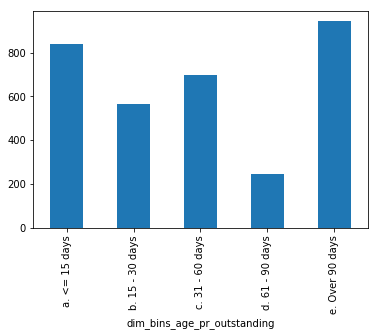

In [0]:
import numpy as np
from matplotlib import pyplot as plt
df_out_purch.groupby('dim_bins_age_pr_outstanding')['dim_bins_age_pr_outstanding'].count().plot.bar()

When a purchase request is initiated, the request is routed into the ERP system. A point supply chain person would then manually assign the request to a category, based on the application of the item. Shown below is a distribution of the outstanding requests.

There are five main categories namely power plant, indirect, civil works and FCRS, Drilling, and Site Fulfillment. As seen below, there are outstanding purchases that are assigned to H00 and "DO NOT USE" - these are staging assignments while an outstanding PR does not have a defined category yet.

Delays would then result in the outstanding purchase requests staying at the staging assignments as they remain to be untouched. 

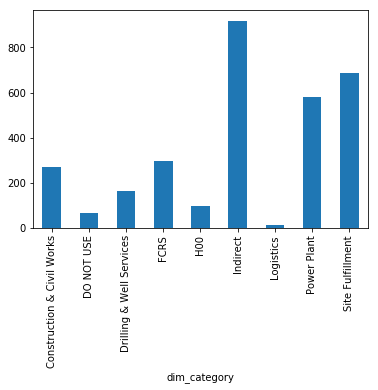

In [0]:
df_out_purch.groupby('dim_category')['dim_category'].count().plot.bar()

With this, the first recommendation that could be automated is the **assigned category**. Automating this portion would allow the routing of purchase requests to be more efficient, especially to those categories with high influx volume of requests, specifically indirect category.

Before a purchase is done however, the **requested item should still be checked with the current inventory to**:
1. Prevent bloating of inventory which would result in increased holding costs; and
2. Frees up more time for buyers to focus on other requests, thereby increasing efficiency of the procurement process. 

This is also done manually by a dedicated inventory analyst.

## Purchase Price Variances
This section aims to explore variances of purchase prices from different vendors. Shown below are the top items which are most frequently bought - to see if there are significant differences when buying from different vendors

In [0]:
df_spend2 = df_spend.loc[(df_spend['Year'] >= 2018) & (df_spend['PO Amount in PHP'] > 1) & (df_spend['Material'] > 0) & (df_spend['Order Unit'] != 'LOT') & (df_spend['Goods / Services'] != 'SERVICES')]
df_spend2['Unit Price in PHP'] = pd.to_numeric(df_spend2['PO Amount in PHP']) / pd.to_numeric(df_spend2['Order Quantity'])
df_purch_price = df_spend2.groupby(['Cleaned Short Text']).agg({'Unit Price in PHP': ['mean', 'median', 'max', 'min', 'count']}).reset_index()
df_purch_price = df_purch_price.sort_values(('Unit Price in PHP','count'), ascending = False)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


As shown below - for a single item, it could have a wide range of unit price even considering that only purchases made within the year are included: e.g safety footwear has a max unit price of PHP17k, and min price of PHP303.

In [0]:
top10 = df_purch_price.head(20)
top10

Cleaned Short Text  ... Unit Price in PHP
                                                ...             count
1646           Drugs & Pharmaceutical Products  ...               691
5242               Tools And General Machinery  ...               600
4909  Structure/Bldg/Construction/Manufactcomp  ...               572
2921          Laboratory Supplies And Fixtures  ...               486
4462                            Safety Apparel  ...               412
2185                              Fuel;Diesel;  ...               356
2184                               Fuel;Diesel  ...               342
3111            Medical Eqpt & Accs & Supplies  ...               341
2189                   Furniture & Furnishings  ...               275
4036      Printer & Fax & Photocopier Supplies  ...               255
4463                           Safety Footwear  ...               241
4027                Prepared & Preserved Foods  ...               230
1195          Cleaning And Janitorial Supplies  ...               225
1523                             Desk Supplies  ...               220
5897                       Writing Instruments  ...               219
1783   Electrical Eqpt And Components And Supp  ...               211
99      Apparel & Luggage & Personal Care Prod  ...               202
1251          Computer Equipment & Accessories  ...               178
4040                Printing And Writing Paper  ...               163
1781       Electrical Controls And Accessories  ...               150

[20 rows x 6 columns]

In [0]:
df_purch_price_spec = df_spend2.loc[df_spend2['Cleaned Short Text'] == 'Safety Footwear']
df_purch_price_spec_analysis = df_purch_price_spec.groupby(['Cleaned Short Text', 'Cleaned Vendor Name']).agg({'Unit Price in PHP': ['mean', 'median', 'max', 'min', 'count']}).reset_index()

Upon looking at the specific suppliers providing the same safety footwear, there is a large disparity depending on the vendor. This may be because of the material - but assuming that the item would serve the same purpose, usage and product life - there may be a need to identify the cheapest vendor.

In [0]:
df_purch_price_spec_analysis

Cleaned Short Text  ... Unit Price in PHP
                       ...             count
0     Safety Footwear  ...                 3
1     Safety Footwear  ...               102
2     Safety Footwear  ...                 6
3     Safety Footwear  ...                11
4     Safety Footwear  ...                63
5     Safety Footwear  ...                 2
6     Safety Footwear  ...                 1
7     Safety Footwear  ...                24
8     Safety Footwear  ...                 3
9     Safety Footwear  ...                24
10    Safety Footwear  ...                 2

[11 rows x 7 columns]

In [0]:
df_purch_price_spec = df_spend2.loc[df_spend2['Cleaned Short Text'] == 'Safety Footwear']
df_purch_price_spec_analysis2 = df_purch_price_spec.groupby(['Cleaned Short Text', 'Plant']).agg({'Unit Price in PHP': ['mean', 'median', 'max', 'min', 'count']}).reset_index()

Plant, also shows the same disparity pattern. This is because purchases before are decentralized, and so buying units from different plants have different strategies

In [0]:
df_purch_price_spec_analysis2

Cleaned Short Text Plant Unit Price in PHP  ...                         
                                         mean  ...       max      min count
0     Safety Footwear  1003       6696.430000  ...   6696.43  6696.43     1
1     Safety Footwear  100A       4613.096667  ...   6696.43  3571.43     3
2     Safety Footwear  100D       7745.865556  ...   9900.00   423.50     9
3     Safety Footwear  100J       2309.325556  ...   8839.29   616.07    45
4     Safety Footwear  310B       2832.590000  ...   3571.43   616.07    20
5     Safety Footwear  320A       3571.430000  ...   3571.43  3571.43     2
6     Safety Footwear  B001       2093.750000  ...   3571.43   616.07     4
7     Safety Footwear  E001       2976.885556  ...  10350.00   303.00    27
8     Safety Footwear  E002       3960.500000  ...   7065.00   616.07    10
9     Safety Footwear  E003       2309.678966  ...   9900.00   380.00    29
10    Safety Footwear  E004       6791.795714  ...  17857.14   570.00     7
11    Safety Footwear  E005       2339.162857  ...   4800.00   468.00    56
12    Safety Footwear  E006       3340.035556  ...  10044.00   468.00     9
13    Safety Footwear  G001       2118.407500  ...   5500.00   380.00     4
14    Safety Footwear  G002       2083.264000  ...   3571.43   468.00    15

[15 rows x 7 columns]

With disparity in purchase prices, what buyers do is to consolidate purchases given an identified supplier which provides the cheapest option. Thus, the recommendation engine later on would tackle on predicting what requests can be bundled together.

#Recommendation Engine Methodology

##Suggestion Feature for Categories

When a purchase request is created, it is routed to different buying groups depending on the item itself. For example, all tissues, office supplies and items not used in production are assigned to Indirect Group. However, assigning the buying group is done manually. Thus, the aim of this section is to create a model on predicting the buying group to be assigned based on the item descriptions that are in the purchase request.

In [0]:
df_spend_test = df_spend[['BCG Level 0', 'Cleaned Short Text']]

In [0]:
df_spend_test['BCG Level 0'].unique()

array([u'FCRS', u'Power Plant', u'Indirect', u'Drilling & Well services',
       u'Construction & Civil works'], dtype=object)

Shown below is a sample of the text descriptions, and the assigned category. This is historical spend data that has a span of about 6 years.

In [0]:
df_spend_test.head()

,BCG Level 0,Cleaned Short Text
0,FCRS,"Actuator; Hydraulic, For 20"" Butterfly V"
1,FCRS,"Actuator; Hydraulic, For 8"" Butterfly Va"
2,Power Plant,Kit;Resolver Drive & Pcb;Iq70F25A;Rotork
3,Power Plant,Kit;Repair;Toshiba Msv Actuator
4,Power Plant,"Kit;Repair;36"" Control Valve Actuator;"


Below shows the model itself - it makes use of multinomial naive bayes that is usually used in text classification problems.

In [0]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

#count_vect = CountVectorizer()
#x_train_counts = count_vect.fit_transform(df_spend_test['Cleaned Short Text'].values.astype('U'))
#tfidf_transformer = TfidfTransformer()
#x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

train_x, test_x, train_y, test_y = train_test_split(df_spend_test['Cleaned Short Text'], df_spend_test['BCG Level 0'], test_size=0.3)
text_test_x = test_x,
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

def transform_text(column_x):
  transformed_x = tfidf_transformer.fit_transform(count_vect.fit_transform(column_x.values.astype('U')))
  return transformed_x

def transform_text2(column_x): #since vectorizer and transformer has been fitted already
  transformed_x = tfidf_transformer.transform(count_vect.transform(column_x.values.astype('U')))
  return transformed_x

train_x = transform_text(train_x)
test_x = transform_text2(test_x)

clf = MultinomialNB().fit(train_x, train_y)
y_score = clf.predict(test_x)

pred_y = clf.predict(test_x)

results = pd.DataFrame({'Material Description': test_x, 'Actual': test_y, 'Predicted': pred_y.flatten()})  
results.head()
#text_test_x[0][0]

,Actual,Material Description,Predicted
113862,Indirect,"(0, 14831)\t0.666125909950769\n (0, 7243)\t...",Indirect
109180,Indirect,"(0, 14831)\t0.666125909950769\n (0, 7243)\t...",Indirect
158678,FCRS,"(0, 14831)\t0.666125909950769\n (0, 7243)\t...",Power Plant
19097,Drilling & Well services,"(0, 14831)\t0.666125909950769\n (0, 7243)\t...",Drilling & Well services
216840,FCRS,"(0, 14831)\t0.666125909950769\n (0, 7243)\t...",FCRS


Using the model to the outstanding purchase requisitions:

In [0]:
y = clf.predict(transform_text2(df_out_purch['dim_po_material_shorttext']))
outstanding_purch_predicted = pd.DataFrame({'PR Number': df_out_purch['id_pr_item'], 'Material Description': df_out_purch['dim_po_material_shorttext'], 'Predicted Category': y})

The model is good at predicting those under Civil works, and indirect; but is not so good at predicting those under power plant, drilling, and fcrs. This is because there are many similar items that are used within these three categories. 

In [0]:
from sklearn import metrics
print (metrics.classification_report(test_y,clf.predict(test_x))) 

                            precision    recall  f1-score   support

Construction & Civil works       0.78      0.74      0.76      5699
  Drilling & Well services       0.92      0.69      0.79      3067
                      FCRS       0.78      0.80      0.79      8815
                  Indirect       0.90      0.94      0.92     42802
               Power Plant       0.69      0.56      0.62      6297

                 micro avg       0.86      0.86      0.86     66680
                 macro avg       0.81      0.75      0.78     66680
              weighted avg       0.85      0.86      0.85     66680



##Bundling Opportunities

###Part I: Creating a Network based on Historical Bundles

Creating bundle networks may be done in a lot of ways. One is looking at those that were bundled before - looking at historical bundles. In this case, one purchase order may serve as one bundle, and from here on a network can be created.



In [0]:
#creating a network of material codes
import networkx as nx
lst = []

for i in range(len(df_spend)-1):
  if df_spend['Purchasing Document'][i] == df_spend['Purchasing Document'][i+1]:
    lst.append([df_spend['Material'][i], df_spend['Material'][i+1]])
    i = i + 1
  else:
    i = i + 1
df_network_material = pd.DataFrame(lst)
df_network_material.rename(columns={0:'Item 1', 1:'Item 2'}, inplace=True)
df_network_material = df_network_material.replace('nan', np.nan)
df_network_material['Item 2'] = df_network_material['Item 2'].str[:-2]
df_network_material['Item 1'] = df_network_material['Item 1'].str[:-2]
df_network_material = df_network_material.dropna()
#df_network_material['Item 1'] = df_network_material['Item 1'].astype(int).astype(str)
#df_network_material['Item 2'] = df_network_material['Item 2'].astype(int).astype(str)
df_network_material['combined'] = df_network_material['Item 1'] + df_network_material['Item 2']
df_network_material2 = df_network_material.groupby(['Item 2','Item 1'])['combined'].count()
df_network_material2 = df_network_material2.reset_index()
df_network_material2 = df_network_material2.iloc[1:, :]
df_network_material2.head()

,Item 2,Item 1,combined
1,100,100,5
2,1000,1226,1
3,1002,996,1
4,1009,1009,4
5,1009,1155,1


Shown below is a visualization of the network of bundles - centered are those items which are always bought with other items, while those in the outside circle are usually bought individually.

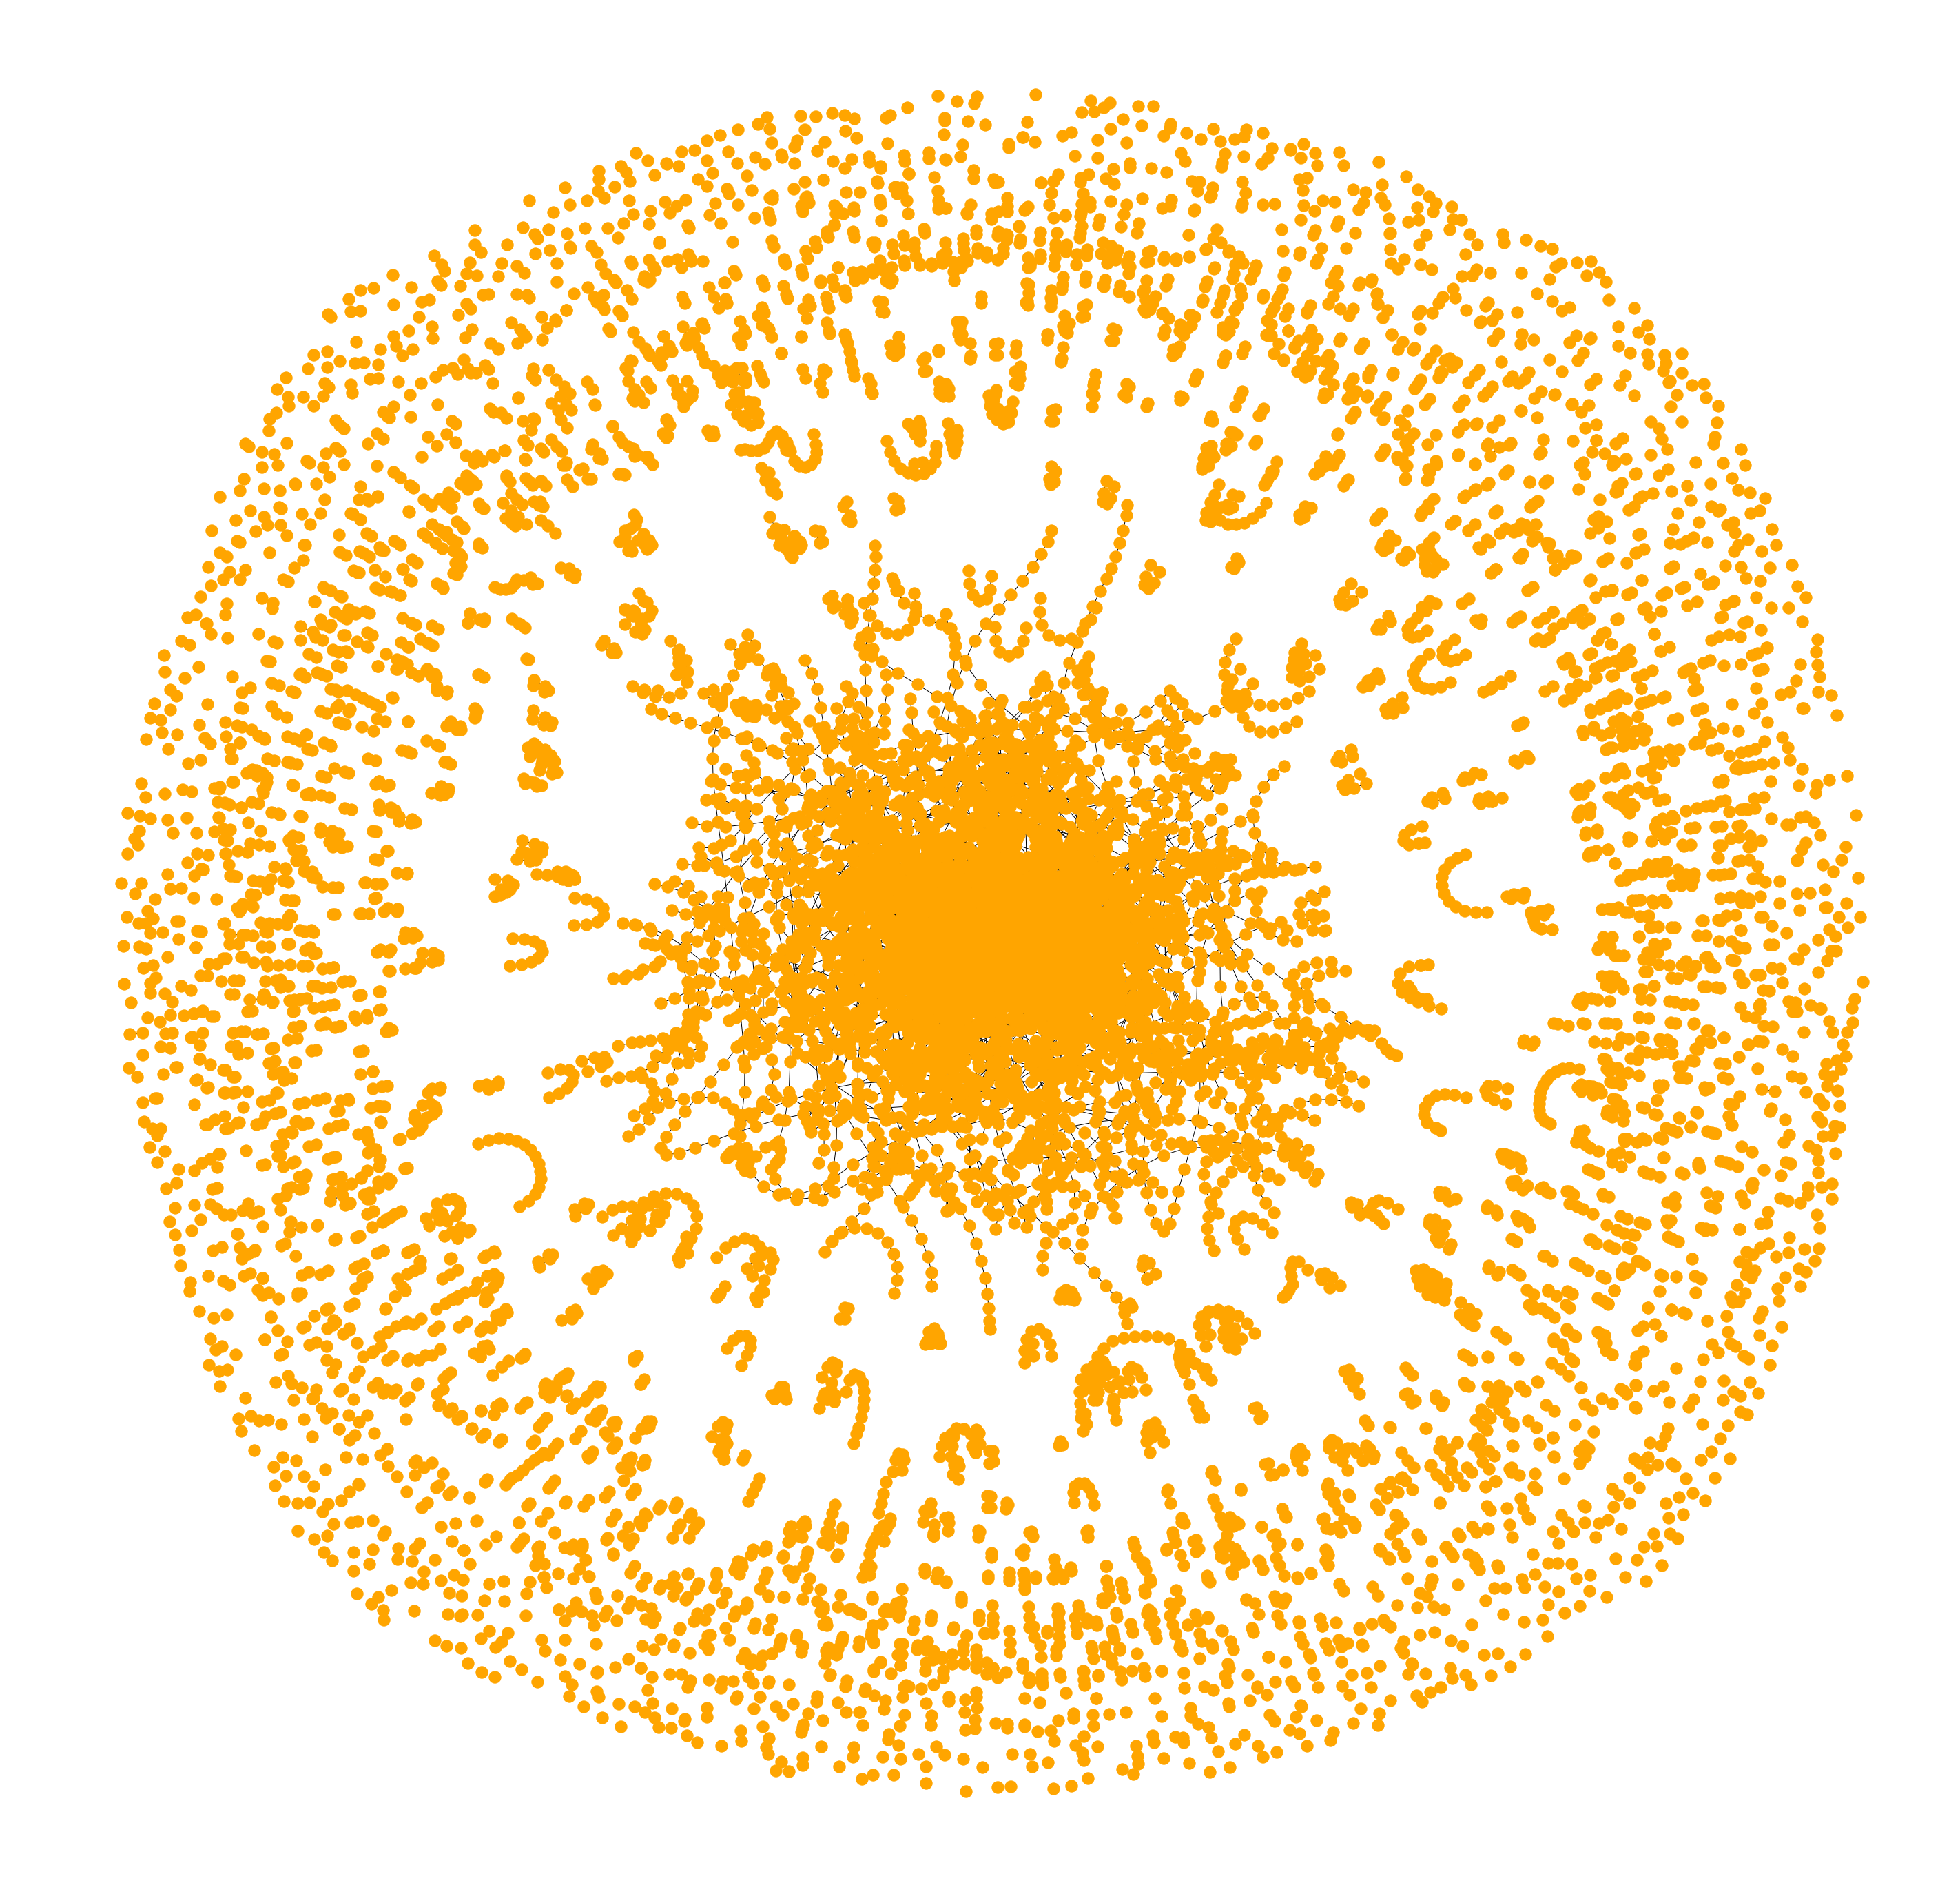

In [0]:
df_network_material4 = df_network_material2.head(1000)
G = nx.from_pandas_edgelist(df_network_material2, 'Item 2', 'Item 1',edge_attr = 'combined')
G2 = nx.from_pandas_edgelist(df_network_material4, 'Item 2', 'Item 1',edge_attr = 'combined')
# larger figure size
plt.figure(3,figsize=(50, 50)) 
pos = nx.random_layout(G)
nx.draw_networkx(G, node_color='orange', with_labels=False) 
plt.axis('off')
plt.show()

It might be interesting to know which of the materials have been bundled the most with other materials. Identifying these may give us an insight on the nature of the business.

(-1.0999459600123822,
 1.0946055041141385,
 -1.0966408094485955,
 1.100256636421134)

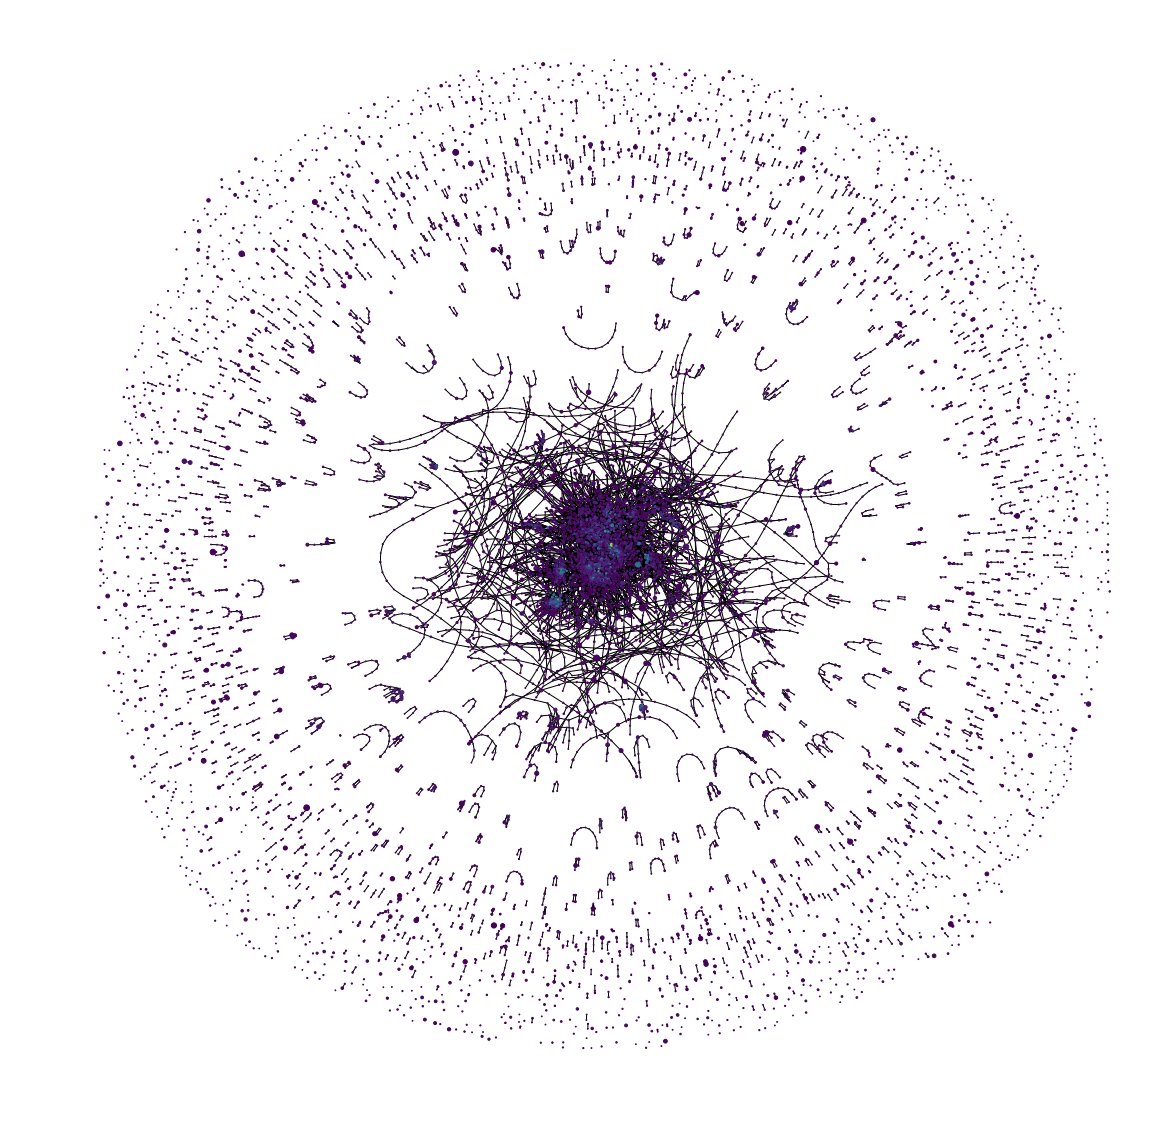

In [0]:
pos = nx.spring_layout(G)
degCent = nx.degree_centrality(G)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in degCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

Below looks at the most central materials based on degree ,magnitude - those that have been bundled the most with other items. This does not look at frequency, but whether an item has been bundled with the most items - in short, the most versatile items that are common with our suppliers.

In [0]:
sorted(betCent, key=betCent.get, reverse=True)[:20] #Top 20 items: weldneck flange, bolt, nipple, paintbrush, stud bolt, thinner, construction materials, elbow, steelbrush, stud bolt, fitting, stud bolt, weldneck flange, stud bolt, weldneck flange, gasket, 

['11537',
 '9176',
 '53976',
 '9574',
 '9260',
 '15161',
 '121778',
 '11118',
 '9598',
 '9137',
 '115114',
 '9131',
 '11562',
 '9089',
 '11522',
 '43545',
 '84252',
 '13042',
 '14928',
 '82530']

In [0]:
pos = nx.spring_layout(G)
betCent = nx.degree_centrality(G)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

Let us look at the item with the highest degree centrality.

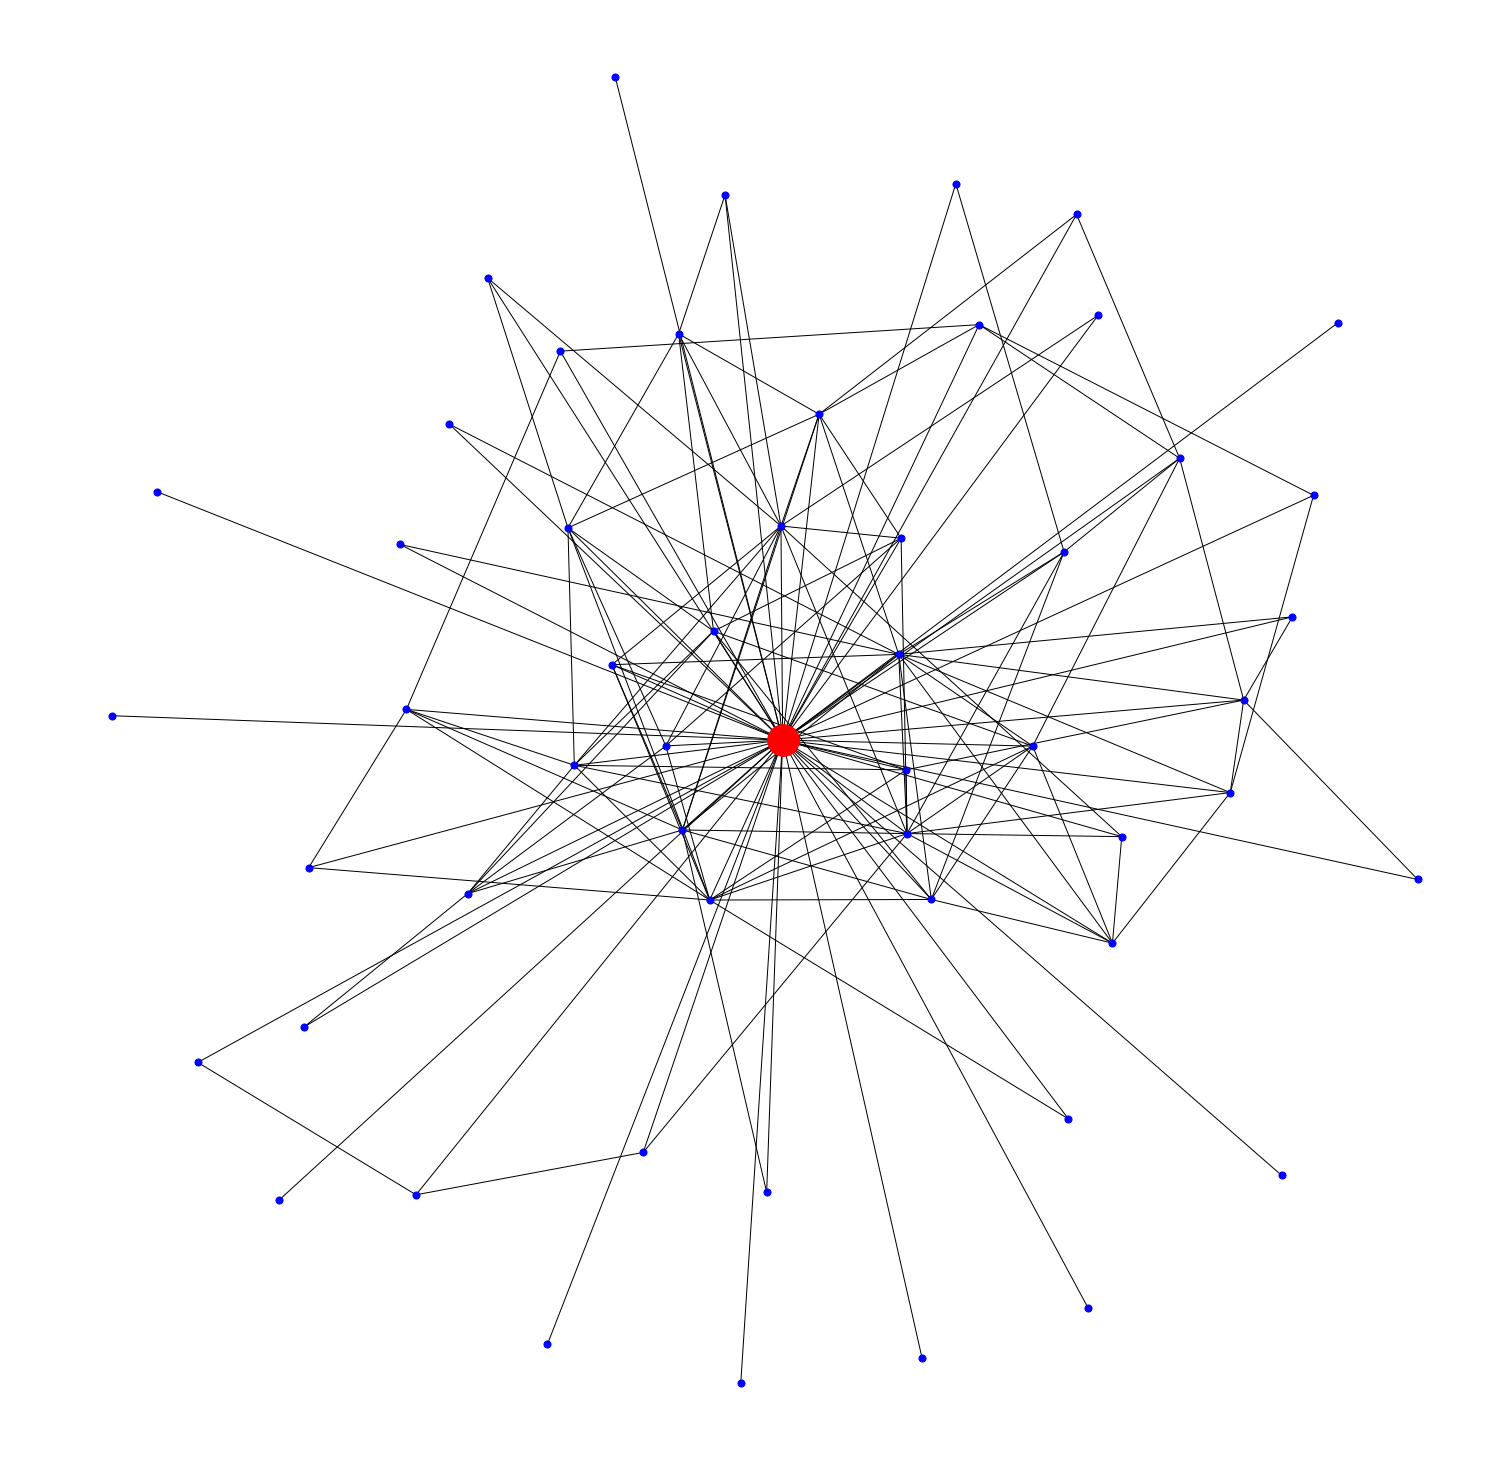

(0.0, 1.0, 0.0, 1.0)

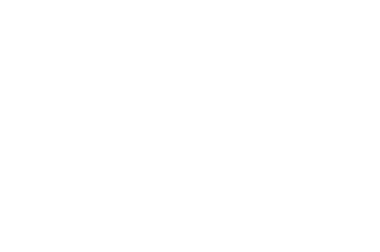

In [0]:
from operator import itemgetter

df_network_material4 = df_network_material2.head(20000)
G = nx.from_pandas_edgelist(df_network_material2, 'Item 2', 'Item 1',edge_attr = 'combined')
G2 = nx.from_pandas_edgelist(df_network_material4, 'Item 2', 'Item 1',edge_attr = 'combined')
# larger figure size
plt.figure(3,figsize=(20, 20)) 
# find node with largest degree
node_and_degree = G.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
# Create ego graph of main hub
hub_ego = nx.ego_graph(G, largest_hub)
# Draw graph
pos=nx.spring_layout(hub_ego)
nx.draw(hub_ego,pos,node_color='b',node_size=50,with_labels=False)
# Draw ego as large and red
nx.draw_networkx_nodes(hub_ego,pos,nodelist=[largest_hub],node_size=1000,node_color='r', with_labels = True)
plt.show()
plt.axis('off')

In [0]:
(largest_hub, degree) #node with highest degree - flange weldneck -range from 327 pesos to 98k per piece; bolts at number 2

('11537', 55)

You see, flanges have the highest degree of relationship, having 55 other connections with other items. However, those are mostly other types of flanges, or other accessories such as bolts. This is because material coding for power plant related items are very refined that a change in dimension would result in another material code. This level of granularity is not present in other items, such as in safety clothing where there is a general matcode for safety footwear. 


What we can infer from the current network is that those with the highest degrees are already refined; while those with low number of degrees can be further specified. Creating a network based on this logic (of using historical bundles) may not open other possibilities of bundling entirely different materials that may complement each other.

In [0]:
nx.edges(G, '11537') #get all connected nodes - this would include elbow, flange, bolts nuts

EdgeDataView([('11537', '11096'), ('11537', '11544'), ('11537', '11522'), ('11537', '11545'), ('11537', '111199'), ('11537', '11525'), ('11537', '11527'), ('11537', '11546'), ('11537', '11535'), ('11537', '11131'), ('11537', '11488'), ('11537', '11561'), ('11537', '11485'), ('11537', '11484'), ('11537', '11564'), ('11537', '11548'), ('11537', '11563'), ('11537', '11509'), ('11537', '120083'), ('11537', '12754'), ('11537', '11503'), ('11537', '11562'), ('11537', '11467'), ('11537', '11466'), ('11537', '11463'), ('11537', '9279'), ('11537', '113486'), ('11537', '11468'), ('11537', '11588'), ('11537', '53976'), ('11537', '13245'), ('11537', '122717'), ('11537', '115114'), ('11537', '11047'), ('11537', '11550'), ('11537', '11552'), ('11537', '11579'), ('11537', '11576'), ('11537', '11575'), ('11537', '11494'), ('11537', '11571'), ('11537', '51538'), ('11537', '11538'), ('11537', '11533'), ('11537', '11514'), ('11537', '11531'), ('11537', '11530'), ('11537', '11537'), ('11537', '11536'), ('

The second item with the most number of degrees is bolt - at 48 degrees. This again suggests that power plant goods are already at a good level of detail granularity

In [0]:
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-2]
largest_hub, degree

('9176', 48)

In [0]:
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[5]
largest_hub, degree

('46136', 1)

In [0]:
#G.edge[edge[0]][edge[1]]['combined']
#G.edges(data = True)
#G['110004','110003']['combined']
#G.edges['110004','110003', 'combined']['weight']

With the network created, prediction of bundles is based on links that could be formed for each pair of material codes. One way to assess linkage of pairs of matcodes is through the preferntial attachment process. It measures the degree of linkage based on historical record of bundled pair of material goods. This process follow the power law, wherein those with large degrees (or were bundled the most based from historical data) are more potent to be bundled again.

In [0]:
def nonedges(G,u):  #a generator with (u,v) for every non neighbor v
    for v in nx.non_neighbors(G, u):
        yield (u, v)
        
import heapq

#preferential attachment
for u in G.nodes():# you may want to check that there will be at least 10 choices.
    preds = nx.preferential_attachment(G,nonedges(G,u))
    
    
#redefined functions in networkx to return 0 when a node is not present in the network
def _apply_prediction2(G, func, ebunch=None):
    if ebunch is None:
        ebunch = nx.non_edges(G)
    return ((u, v, func(u, v)) for u, v in ebunch)

def preferential_attachment2(G, ebunch=None):
    def predict(u, v):
        
        if type(G.degree(u)) == int:
          degree_u = G.degree(u)
        else:
          degree_u = 0
          
        if type(G.degree(v)) == int:
          degree_v = G.degree(v)
        else:
          degree_v = 0
          
        return degree_u * degree_v
    return _apply_prediction2(G, predict, ebunch)

Below are just dataframe transforms, and application of the scores from the preferential attachment process. Showing all material code pairs with more than 1 degree of linkage, the recommended list of all PRs to be bundled are also listed.

In [0]:
lst2 = []
df_matcode_outpurch = df_out_purch
df_matcode_outpurch = df_matcode_outpurch.dropna()
df_matcode_outpurch = df_matcode_outpurch.reset_index()
for i in range(len(df_matcode_outpurch)):
  for j in range(len(df_matcode_outpurch)):
    if df_matcode_outpurch['dim_po_material_code'][i] != df_matcode_outpurch['dim_po_material_code'][j]:
      lst2.append([df_matcode_outpurch['dim_po_material_code'][i], df_matcode_outpurch['dim_po_material_code'][j], df_matcode_outpurch['id_pr_item'][i], df_matcode_outpurch['id_pr_item'][j]])
df_network_outstanding = pd.DataFrame(lst2)
df_network_outstanding.rename(columns={0:'Item 1', 1:'Item 2', 2:'PR Number 1', 3: 'PR Number 2'}, inplace=True)  
df_network_outstanding['Item 1'] = df_network_outstanding['Item 1'].astype(int).astype(str)
df_network_outstanding['Item 2'] = df_network_outstanding['Item 2'].astype(int).astype(str)

subset = df_network_outstanding[['Item 1', 'Item 2']]
list2 = [tuple(x) for x in subset.values]
predict_list = []
prediction = preferential_attachment2(G, list2) #sample iterating over 2 mat codes
for u, v, p in prediction:
  predict_list.append(p)
df_network_outstanding['link_predict'] = predict_list

df_unique_mat_link = df_network_outstanding.drop_duplicates(['Item 1', 'Item 2'])
df_unique_mat_link = df_unique_mat_link.loc[df_unique_mat_link['link_predict'] > 50]

bundle_list = df_unique_mat_link.groupby('PR Number 1').agg({'PR Number 2' : lambda x: ', '.join(x)})
bundle_list = bundle_list.reset_index()

###Part II: Creating a Network based on items that can be bought from the same supplier

Given that relying on historical bundles would only cluster very-similar items (flanges of different dimensions, or all bolts and nuts), another network that can be built is based on whether we have bought items from the same supplier. This looks at all services or goods that are offered by suppliers in a given industry. In this way, we can somewhat create bundles that are more intuitive - for example bundling cleaning chemicals with maintenance activities. 

In [0]:
#creating a network of material codes
lst = []

df_spend.sort_values(by=['Name of Vendor'], inplace=True)

for i in range(len(df_spend)-1):
  if df_spend['Name of Vendor'][i] == df_spend['Name of Vendor'][i+1]:
    lst.append([df_spend['Material'][i], df_spend['Material'][i+1]])
    i = i + 1
  else:
    i = i + 1
df_network_material = pd.DataFrame(lst)
df_network_material.rename(columns={0:'Item 1', 1:'Item 2'}, inplace=True)
df_network_material = df_network_material.replace('nan', np.nan)
df_network_material['Item 2'] = df_network_material['Item 2'].str[:-2]
df_network_material['Item 1'] = df_network_material['Item 1'].str[:-2]
df_network_material = df_network_material.dropna()
df_network_material['combined'] = df_network_material['Item 1'] + df_network_material['Item 2']
df_network_material3 = df_network_material.groupby(['Item 2','Item 1'])['combined'].count()
df_network_material3 = df_network_material3.reset_index()
df_network_material3 = df_network_material3.iloc[1:, :]
df_network_material3.head()

,Item 2,Item 1,combined
1,100,100,7
2,100,11,1
3,1000,1226,1
4,1002,996,1
5,1009,1009,4


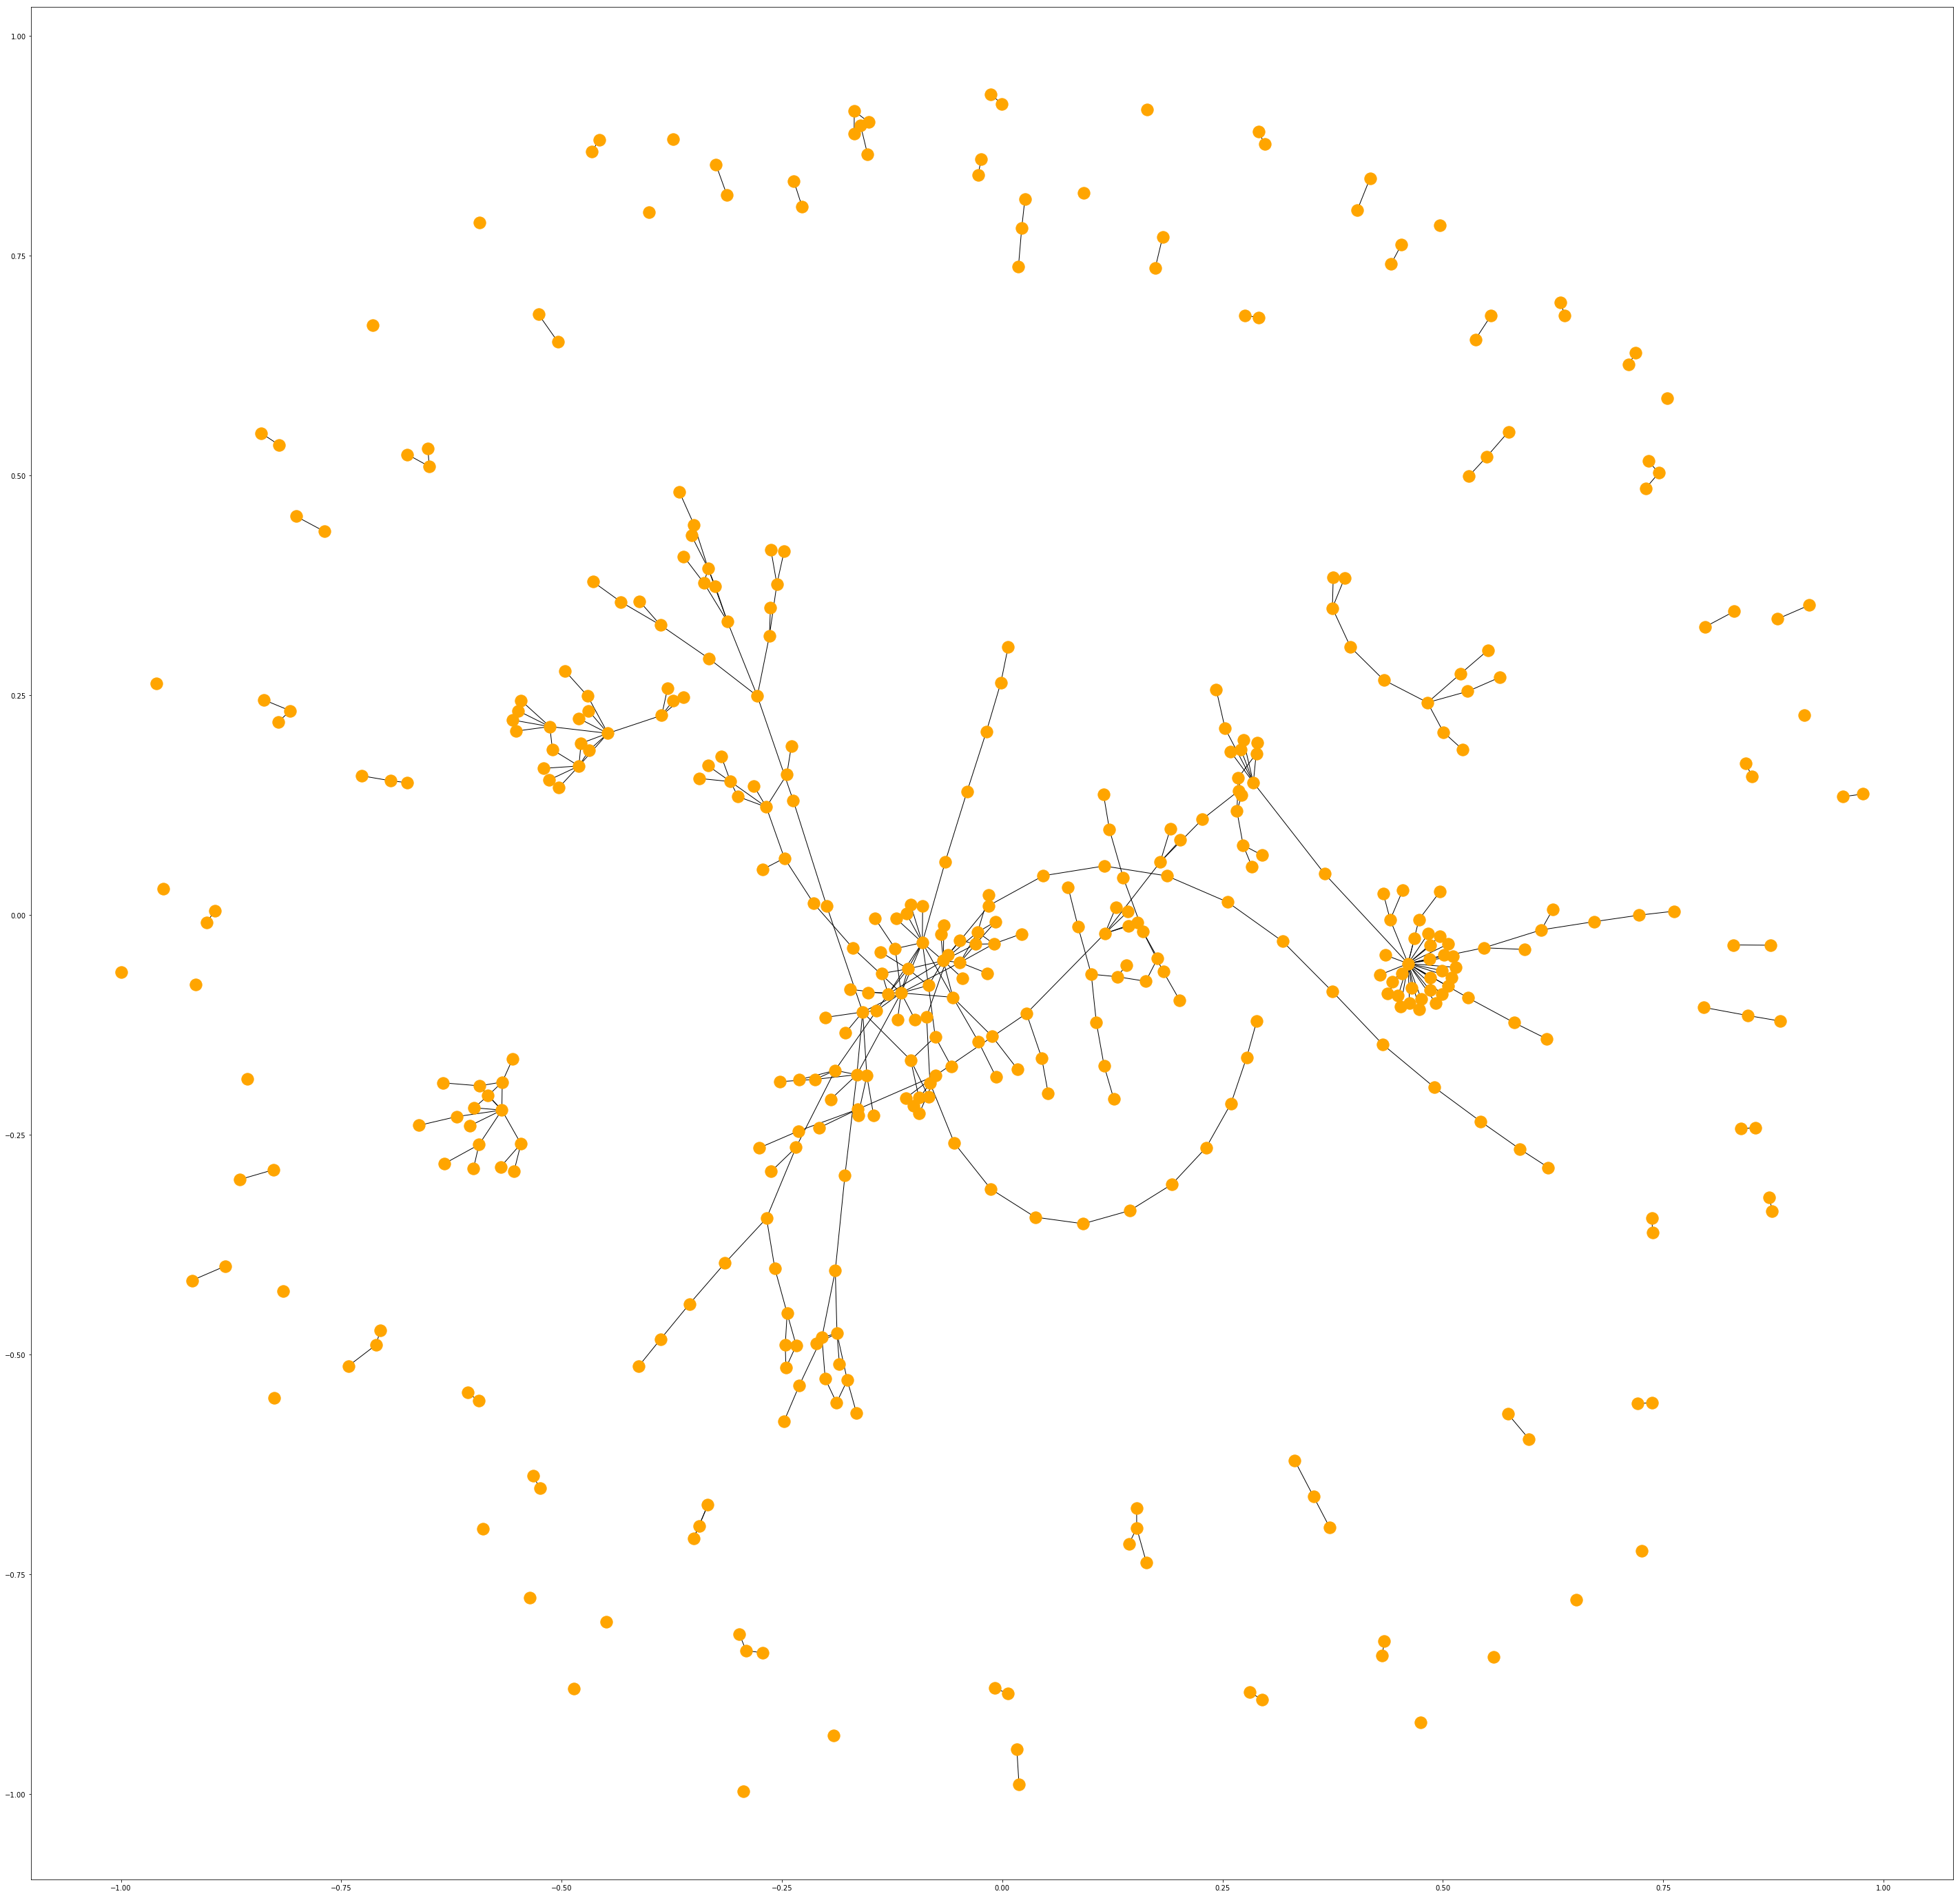

(0.0, 1.0, 0.0, 1.0)

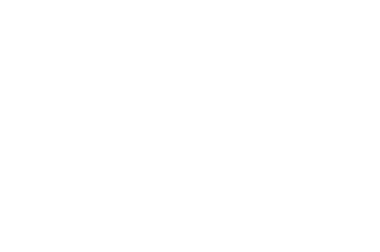

In [0]:
df_network_material4 = df_network_material3.head(500)
H = nx.from_pandas_edgelist(df_network_material3, 'Item 2', 'Item 1',edge_attr = 'combined')
H2 = nx.from_pandas_edgelist(df_network_material4, 'Item 2', 'Item 1',edge_attr = 'combined')
# larger figure size
plt.figure(3,figsize=(50, 50)) 
pos = nx.random_layout(H2)
nx.draw_networkx(H2, node_color='orange', with_labels=False) 
plt.show()
plt.axis('off')

Given this network, let us try to look into the material code with the highest degree of relationship

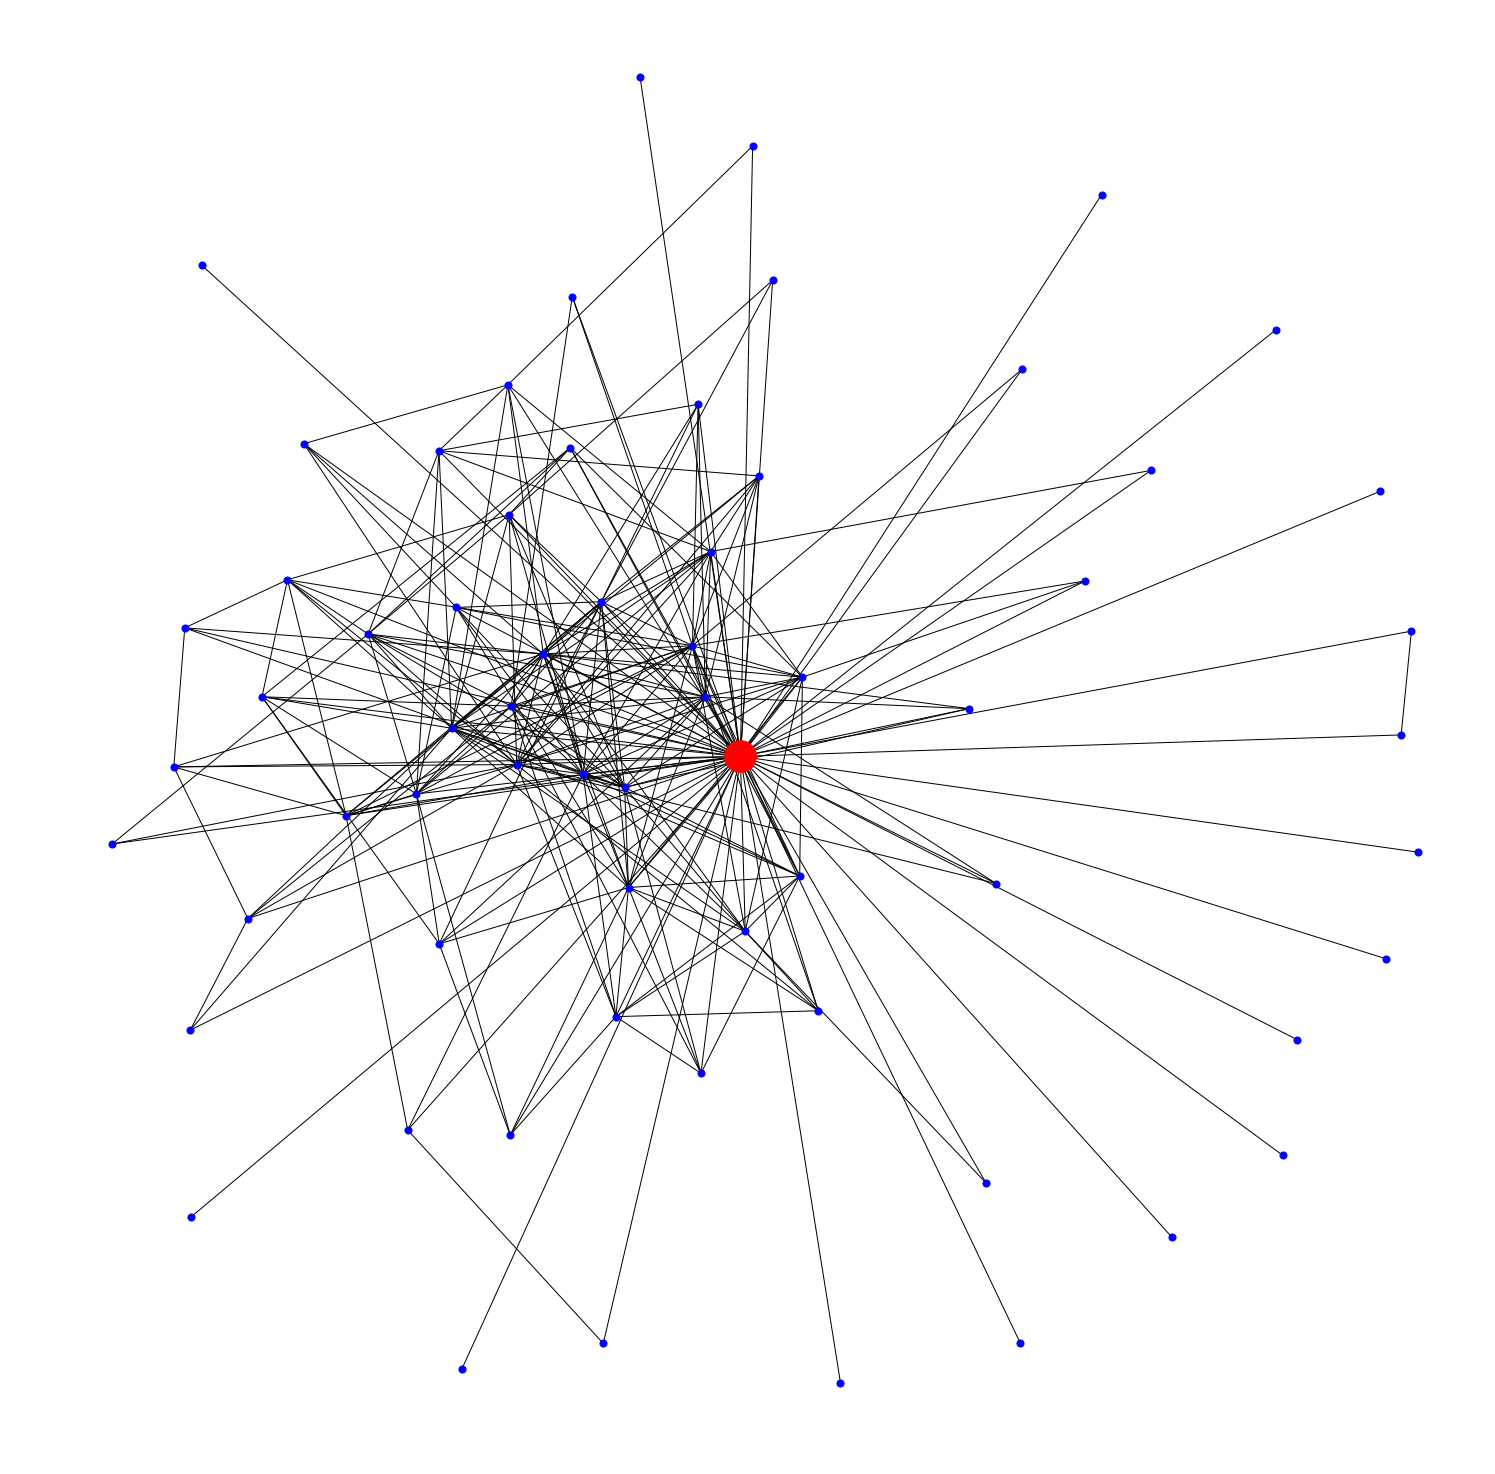

(0.0, 1.0, 0.0, 1.0)

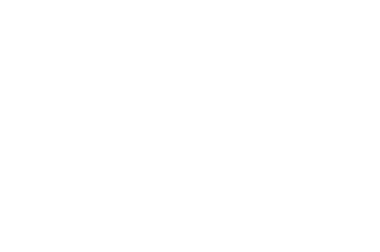

In [0]:
# find node with largest degree
node_and_degree = H.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
# Create ego graph of main hub
hub_ego = nx.ego_graph(H, largest_hub)
plt.figure(3,figsize=(20, 20)) 
# Draw graph
pos=nx.spring_layout(hub_ego)
nx.draw(hub_ego,pos,node_color='b',node_size=50,with_labels=False)
# Draw ego as large and red
nx.draw_networkx_nodes(hub_ego,pos,nodelist=[largest_hub],node_size=1000,node_color='r', with_labels = True)
plt.show()
plt.axis('off')

Thinner, having 66 degrees of relationship, somewhat validates the concern of intuition. You see, many suppliers offer selling thinners, along with materials related to bolts, nuts and other stuff. Bundling these items would really save time, and simplify purchases.

In [0]:
(largest_hub, degree) #thinner 

('15161', 66)

In [0]:
predict_list = []
prediction = preferential_attachment2(H, list2) #sample iterating over 2 mat codes
for u, v, p in prediction:
  predict_list.append(p)
df_network_outstanding['link_predict2'] = predict_list

df_unique_mat_link = df_network_outstanding.drop_duplicates(['Item 1', 'Item 2'])
df_unique_mat_link = df_unique_mat_link.loc[df_unique_mat_link['link_predict2'] > 50]

bundle_list2 = df_unique_mat_link.groupby('PR Number 1').agg({'PR Number 2' : lambda x: ', '.join(x)})
bundle_list2 = bundle_list2.reset_index()
bundle_list2.head()

,PR Number 1,PR Number 2
0,1000056707_00010,"4000066670_00010, 4000063822_00010"
1,1000057014_00010,"4000066891_00010, 1000057294_00010, 4000066670..."
2,1000057294_00010,"1000066036_00010, 1000059123_00010, 1000059560..."
3,1000059123_00010,"1000057294_00010, 4000066670_00010, 4000066337..."
4,1000059560_00010,"4000066891_00010, 1000057294_00010, 4000066670..."


### Part III: Filtering the Network based on Business Logic - Proximity of delivery dates

Practically in our industry, purchase requests that are not required within the next 90 days for example are not done immediately mainly because contracting process is very long. Thus, bundling opportunity is held by required delivery dates - those that have close deadlines buyers try to prioritize first. Thus, to capture this contraint, what can be done is to create clusters of required delivery dates to further refine and calibrate bundling opportunities.

In [0]:
import datetime
df_spend['Delivery Date'] =  pd.to_datetime(df_spend['Delivery Date']) #converting delivery dates to date format
df_out_purch['sla_delivery_target_date'] =  pd.to_datetime(df_out_purch['sla_delivery_target_date']) #converting delivery dates to date format
df_spend['date_difference'] = (df_spend['Delivery Date'] - datetime.datetime(2018, 6, 1))/np.timedelta64(1, 'D')
df_out_purch['date_difference'] = (df_out_purch['sla_delivery_target_date'] - datetime.datetime(2018, 6, 1))/np.timedelta64(1, 'D')
df_out_purch.head()

,dim_po_material_shorttext,id_pr_item,dim_buyer_name,sla_po_release_target_date,dim_storage_loc,dim_category,time_pr_created,dim_bins_age_pr_outstanding,dim_goods_services,dim_po_material_code,sla_delivery_target_date,dim_po_vendor,zmm_id_pr_item,zmm_material,zmm_pr_qty,date_difference
0,Interest Exp_Office Space_OCC 2020,7100000518_00030,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,NaN,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00030,NaN,1.0,320.0
1,Interest Exp_Office Space_OCC 2021,7100000518_00040,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,NaN,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00040,NaN,1.0,320.0
2,Interest Exp_Office Space_OCC 2022,7100000518_00050,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,NaN,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00050,NaN,1.0,320.0
3,Interest Exp_Office Space_OCC 2023,7100000518_00060,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,NaN,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00060,NaN,1.0,320.0
4,Interest Exp_Office Space_OCC 2024,7100000518_00070,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,NaN,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00070,NaN,1.0,320.0


In clustering the dates however, one thing we can do is to convert these into numbers (in this case, get the difference from a single arbitrary date), and then cluster the converted values using MeanShift.

In [0]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

x = df_out_purch['date_difference']
X = np.array(zip(x,np.zeros(len(x))), dtype=np.int)
bandwidth = estimate_bandwidth(X, quantile=0.1)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

#for k in range(n_clusters_):
    #my_members = labels == k
    #print "cluster {0}: {1}".format(k, X[my_members, 0])
    #print k, X[my_members, 0]

Shown below are material pairings from outstanding purchase requests, and preferrential attachment score from first and second network. This two networks are to be combined, and their preferrential attachment score will be assessed later. The reason behind combining these two networks is to capture what bundles we we have done before, and what other bundles we can do on top of what has been done before. 

In [0]:
df_network_outstanding['link_combine'] = df_network_outstanding['link_predict'] + df_network_outstanding['link_predict2']
df_network_outstanding.head()

,Item 1,Item 2,PR Number 1,PR Number 2,link_predict,link_predict2,link_combine
0,10799,14006,1000066036_00010,1000065495_00010,0,0,0
1,10799,14639,1000066036_00010,1000059123_00010,20,24,44
2,10799,15732,1000066036_00010,1000059560_00010,25,30,55
3,10799,15733,1000066036_00010,1000057014_00010,40,48,88
4,10799,18751,1000066036_00010,4000066891_00010,30,66,96


Given the first network - we identify the preferential attachment score per material pair in the list of outstanding purchases. With the clusters of close delivery dates identified, the goal of the following procedures is to reflect this clusters in the dataframe

In [0]:
df_out_purch['cluster'] = labels
df_unique_out_purch = df_out_purch.drop_duplicates(['id_pr_item'])

df_unique_out_purch['cluster2'] = df_unique_out_purch['cluster']
mat_pair = df_unique_mat_link.merge(df_unique_out_purch[['id_pr_item','cluster']], left_on = 'PR Number 1', right_on = 'id_pr_item', how = 'left')
mat_pair = mat_pair.merge(df_unique_out_purch[['id_pr_item', 'cluster2']], left_on = 'PR Number 2', right_on = 'id_pr_item', how = 'left')
mat_pair['link_combine'] = mat_pair['link_predict'] + mat_pair['link_predict2']
#mat_pair = mat_pair.drop

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
mat_pair.head()

,Item 1,Item 2,PR Number 1,PR Number 2,link_predict,link_predict2,id_pr_item_x,cluster,id_pr_item_y,cluster2,link_combine
0,10799,18751,1000066036_00010,4000066891_00010,30,66,1000066036_00010,0,4000066891_00010,0,96
1,10799,51058,1000066036_00010,1000057294_00010,80,144,1000066036_00010,0,1000057294_00010,5,224
2,10799,72847,1000066036_00010,4000066670_00010,25,156,1000066036_00010,0,4000066670_00010,0,181
3,10799,82485,1000066036_00010,4000066337_00010,35,108,1000066036_00010,0,4000066337_00010,1,143
4,10799,82585,1000066036_00010,4000066197_00070,25,60,1000066036_00010,0,4000066197_00070,1,85


In [0]:
mat_pair = mat_pair[['Item 1', 'Item 2', 'PR Number 1', 'PR Number 2', 'link_predict', 'link_predict2', 'link_combine', 'cluster', 'cluster2']]
mat_pair['include'] = mat_pair['cluster'] == mat_pair['cluster2']
mat_pair_final = mat_pair.loc[(mat_pair['include'] == True)]
mat_pair_final

,Item 1,Item 2,PR Number 1,PR Number 2,link_predict,link_predict2,link_combine,cluster,cluster2,include
0,10799,18751,1000066036_00010,4000066891_00010,30,66,96,0,0,True
2,10799,72847,1000066036_00010,4000066670_00010,25,156,181,0,0,True
7,10799,116020,1000066036_00010,4000066670_00030,55,72,127,0,0,True
21,15733,51058,1000057014_00010,1000057294_00010,128,192,320,5,5,True
31,18751,10799,4000066891_00010,1000066036_00010,30,66,96,0,0,True
35,18751,72847,4000066891_00010,4000066670_00010,30,286,316,0,0,True
42,18751,116020,4000066891_00010,4000066670_00030,66,132,198,0,0,True
44,50971,72847,1000066606_00010,4000066670_00010,10,52,62,0,0,True
49,51058,15733,1000057294_00010,1000057014_00010,128,192,320,5,5,True
61,72847,10799,4000066670_00010,1000066036_00010,25,156,181,0,0,True


Overall, there are 26 pairs of purchase requests that can be bundled. These may be further grouped together as some pairs may still be grouped with others.

In [0]:
len(mat_pair_final)

26

Shown below are the bundles predicted from the combined network scores, and with the additional layer of the required delivery dates being close to each other. The bundles only represent less than 5% of the overall outstanding purchase requests, but enriching bundling practices may further improve historical data, which would suggest more "bundles".

In [0]:
final_bundle = mat_pair_final.groupby('PR Number 1').agg({'PR Number 2' : lambda x: ', '.join(x)})
final_bundle = final_bundle.reset_index()
final_bundle

,PR Number 1,PR Number 2
0,1000057014_00010,1000057294_00010
1,1000057294_00010,1000057014_00010
2,1000066036_00010,"4000066891_00010, 4000066670_00010, 4000066670..."
3,1000066606_00010,4000066670_00010
4,4000064826_00040,4000065089_00010
5,4000065089_00010,4000064826_00040
6,4000066197_00070,"4000066337_00010, 4000066201_00010"
7,4000066201_00010,"4000066337_00010, 4000066197_00070"
8,4000066337_00010,"4000066201_00010, 4000066197_00070"
9,4000066670_00010,"1000066036_00010, 4000066891_00010, 1000066606..."


#Inventory on Stock
This section looks at 2 parts - first looks on whether some of the outstanding PRs are still available in the inventory in stock; and second part would look at inventory withdrawal patterns to predict if there is a need to withdraw and create additional PRs.

In [0]:
df_out_purch['dim_po_material_code'] = df_out_purch['dim_po_material_code'].fillna(0)
df_out_purch['dim_po_material_code'] = df_out_purch['dim_po_material_code'].astype(int).astype(str)
df_out_purch = df_out_purch.merge(df_inv_stock, left_on = 'dim_po_material_code', right_on = 'Material', how = 'left')
df_out_purch['inv_difference'] = df_out_purch['Unrestricted'] - df_out_purch['zmm_pr_qty']

def decision(df):

    if df['inv_difference'] > 0:
      return 'withdraw from inventory, there are still '+ str(df['Unrestricted']) + ' units left'
    elif df['inv_difference'] < 0:
      return 'Not enough inventory, proceed with the purchase'
    else:
      return 'not in current inventory data'
    
df_out_purch['inventory_decision'] = df_out_purch.apply(decision, axis = 1)

In [0]:
df_out_purch.head(50)

,dim_po_material_shorttext,id_pr_item,dim_buyer_name,sla_po_release_target_date,dim_storage_loc,dim_category,time_pr_created,dim_bins_age_pr_outstanding,dim_goods_services,dim_po_material_code,sla_delivery_target_date,dim_po_vendor,zmm_id_pr_item,zmm_material,zmm_pr_qty,date_difference,cluster,Site,Plant,Storage Location,Material,Material Description,DF stor. loc. level,Base Unit of Measure,Unrestricted,Currency,Value Unrestricted,Transit and Transfer,Val. in Trans./Tfr,In Quality Insp.,Value in QualInsp.,Restricted-Use Stock,Value Restricted,Blocked,Value BlockedStock,Returns,Value Rets Blocked,inv_difference,inventory_decision
0,Interest Exp_Office Space_OCC 2020,7100000518_00030,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,0,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00030,NaN,1.0,320.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in current inventory data
1,Interest Exp_Office Space_OCC 2021,7100000518_00040,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,0,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00040,NaN,1.0,320.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in current inventory data
2,Interest Exp_Office Space_OCC 2022,7100000518_00050,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,0,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00050,NaN,1.0,320.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in current inventory data
3,Interest Exp_Office Space_OCC 2023,7100000518_00060,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,0,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00060,NaN,1.0,320.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in current inventory data
4,Interest Exp_Office Space_OCC 2024,7100000518_00070,GV Deloria,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,0,2019-04-17,5000000 AMBERLAND CORPORATION,7100000518_00070,NaN,1.0,320.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in current inventory data
5,Interest_Exp_Office Space_RBC10 2020,7100000519_00030,MO Amador,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,0,2019-04-17,5000007 ROCKWELL-MERALCO BPO VENTURE,7100000519_00030,NaN,1.0,320.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in current inventory data
6,Interest_Exp_Office Space_RBC10 2021,7100000519_00040,MO Amador,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,0,2019-04-17,5000007 ROCKWELL-MERALCO BPO VENTURE,7100000519_00040,NaN,1.0,320.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in current inventory data
7,Interest_Exp_Office Space_RBC10 2022,7100000519_00050,MO Amador,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,0,2019-04-17,5000007 ROCKWELL-MERALCO BPO VENTURE,7100000519_00050,NaN,1.0,320.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in current inventory data
8,Interest_Exp_Office Space_RBC10 2023,7100000519_00060,MO Amador,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Over 90 days,SERVICES,0,2019-04-17,5000007 ROCKWELL-MERALCO BPO VENTURE,7100000519_00060,NaN,1.0,320.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not in current inventory data
9,Interest_Exp_Office Space_RBC10 2024,7100000519_00070,MO Amador,2019-03-10 00:00:00.000000,HO CENTRAL,Indirect,2019-01-17 00:00:00.000000,e. Ov

As can be seen below - checking on inventory data would lessen the total frequency of purchase. 867 out of all 2934 outstanding purchase requests may be withdrawn from inventory

In [0]:
len(df_out_purch.loc[df_out_purch['inv_difference'] > 0])

768

In [0]:
df_out_purch.to_csv('yeah7.csv', encoding='latin1')

##Time between withdrawals (Work in progress)
This section would identify the reorder points. In a usual manufacturing business, restocking of inventory is based on customer demand. However, in energy industry, inventory of spare parts is greatly reliant on breakdown of plants. Thus, reorder points are based on time between failures of machines.

For the sake of identifying the time between failures of machines, we can assume that the time between withdrawals of items is equal to the time between failures. 

Thus, what the next section would do is to get the distribution of time between withdrawals of each material.

In [0]:
df_inv_move['Posting Date'] =  pd.to_datetime(df_out_purch['sla_delivery_target_date']) #converting delivery dates to date format
df_spend['date_difference'] = (df_spend['Delivery Date'] - datetime.datetime(2018, 6, 1))/np.timedelta64(1, 'D')

In [0]:
df_inv_move['Posting Date'] =  pd.to_datetime(df_inv_move['Posting Date'])
df_inv_move = df_inv_move.sort_values('Material', ascending = True)